Subgroup effective drugs are defined as:

A criterion was needed for designating drug as effective or ineffective in each subgroup. Requiring the same number of hits across subgroups would unduly favor larger subgroups, while requiring the same fraction of hits would unduly favor smaller subgroups. Instead we required that it be effective in enough samples to achieve a specified confidence that, in the limit, the frequency of efficacy in similar samples would exceed a given threshold. The required number of hits is k = F^{-1}(1- \alpha; n, p), where F(k;n,p)= \sum_{i=0}^{k}{ \binom{n}{i}p^i (1-p)^{(n-i)}} is the cumulative distribution of the binomial distribution and n is the number of tumors of the subgroup in question. We chose =0.05, corresponding to 95% confidence, and p=0.5. 

**This required efficacy in 8 of 10 G3 tumors, 5 of 6 SHH tumors, and 4 of 4 G4 tumors.**

In [112]:
import pandas as pd
min_hits = pd.Series(data=[8,4,5,3], index=['G3','G4','SHH','SHH+p53'])
min_hits

G3         8
G4         4
SHH        5
SHH+p53    3
dtype: int64

In [4]:
import ccalnoir as ccal
import cuzcatlan as cusca
import os

In [16]:
def cls_to_boolean(file):
    with open(file) as f:
        f.readline()
        f.readline()
        line = f.readline()
        vals = line.strip('\n').split(' ')
    return [bool(int(val)) for val in vals]

## Find effective drugs per PDX

In [104]:
# Read all drug scores
all_scores = pd.read_table(all_drug_scores, header=2, index_col=0).drop(['Description'],axis=1)

#Define a hit as drugs above certain percentile
# which_percentile = 99.9 # this is what it was for the drug screen
which_percentile = 90
which_quantile = which_percentile/100

thresholds = all_scores.apply(lambda x: x.quantile(which_quantile), axis=0)
print(f"Computed threshold for the {which_percentile}-th percentile({which_quantile}-th quantile)")
# pd.DataFrame(thresholds).T

Computed threshold for the 90-th percentile(0.9-th quantile)


In [162]:
per_pdx_hits = all_scores>=thresholds

# From: https://xlsxwriter.readthedocs.io/example_pandas_conditional.html
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('results/hits_per_pdx.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
per_pdx_hits.to_excel(writer, sheet_name='Effective Drugs')

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Effective Drugs']

# Apply a conditional format to the cell range.

# Black fill with light gray text.
true_format = workbook.add_format({'bg_color':   '#000000',
                                   'font_color': '#444444'})
# White fill with light gray text.
false_format = workbook.add_format({'bg_color':   '#FFFFFF',
                                    'font_color': '#AAAAAA'})

# B1 toU673 is very specific to these results
worksheet.conditional_format('B1:U673', {'type':     'text',
                                         'criteria': 'containing',
                                         'value':    'TRUE',
                                         'format':   true_format})
worksheet.conditional_format('B1:U673', {'type':     'text',
                                         'criteria': 'containing',
                                         'value':    'FALSE',
                                         'format':   false_format})

# Close the Pandas Excel writer and output the Excel file.
writer.save()

print("Successfully wrote and formated file: `results/hits_per_pdx.xlsx`")
# per_pdx_hits

Successfully wrote and formated file: `results/hits_per_pdx.xlsx`


TypeError: unhashable type: 'list'

TypeError: unhashable type: 'list'

In [98]:
# Maybe add sheets for unique hits?

## Find hits per subgroup

In [161]:
writer = pd.ExcelWriter('results/hits_subgroup_effective.xlsx', engine='xlsxwriter')
first_subgroup = True
for subgroup in ['G4']:
    if not os.path.exists(f'results/{subgroup}'):
        os.makedirs(f'results/{subgroup}')
    
    phenotype_file=f'results/{subgroup}.cls'
    subgroup_output_filename=f'results/{subgroup}/subgroup_effective.xlsx'
    
    sugbroup_bool = cls_to_boolean(phenotype_file)
    #This assumes per_pdx_hits was generated in a cell above
    subgroup_scores = per_pdx_hits[per_pdx_hits.columns[sugbroup_bool]]
    drug_passes_test = subgroup_scores.sum(axis=1)>=min_hits[subgroup]
    drug_passes_test.name = subgroup
    if first_subgroup:
        hits_per_subgroup = pd.DataFrame(drug_passes_test)
        first_subgroup = False
    else:
        hits_per_subgroup.join(drug_passes_test)
    
    ### INDEX>???
    drug_passes_test.to_excel(writer,sheet_name=f'{subgroup}')
    print(f'Sheet named "{subgroup}" added successfully to file named "results/hitssubgroup_effective.xlsx"!')

#EDWIN: Add formatting (put them all in one sheet first)
writer.save()

    

[False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, True]
Sheet named "G4" added successfully to file named "results/hitssubgroup_effective.xlsx"!


In [3]:
# This could be a for loop, but it is cleaner as a function
def create_subgroup_reports(subgroup, pearson=True,number_of_permutations=10):
    
    number_of_permutations

    print('-----')
    print(f"Determinig drug hits per PDX for the {subgroup} subgroup")
    read_cls(f'results/{subgroup}.cls')
    print('-----')
    significance = pd.read_table(f'results/{subgroup}/significance.match.txt',index_col=0)
    effective_drugs = significance[significance['Score']>0]
    effective_drugs.drop(['Score(0.95 MoE)'],axis=1,inplace=True)
    # load info for all drugs:
    pdx_df = pd.read_excel('results/drug_scores_for_all_pdx_models.xlsx')
    # Add MoAs to effective drug
    effective_drugs.insert(loc=0,column='MoA',value=pdx_df['moa'])
    #Saving individual results to a spreadsheet.
    effective_drugs.to_excel(f'results/{subgroup}/{subgroup}_effective_drugs_from_expression.xlsx')
    print(f'File named "results/{subgroup}/{subgroup}_effective_drugs_from_expression.xlsx" saved successfully!')
    print('-----')
    print("Effective drugs (i.e., drugs with Score>0)")
    display(effective_drugs)

In [4]:
def concatenate_subgroup_reports():
    """Assuming that individual reports exist!"""
    writer = pd.ExcelWriter('results/effective_drugs_from_expression.xlsx')
    for subgroup in ['G3','G4','SHH','SHH+p53']:  
        #Saving results to a sheet in a summary 
        effective_drugs = pd.read_excel(f'results/{subgroup}/{subgroup}_effective_drugs_from_expression.xlsx',index_col=0)
        effective_drugs.to_excel(writer,sheet_name=f'{subgroup}')
        print(f'Sheet named "{subgroup}" added successfully to file named "results/effective_drugs_from_expression.xlsx"!')
    writer.save()
    print("All done!")

In [5]:
number_of_permutations = 100
pearson=False

==> Using Information Coefficient as the "Score"
Dropping 0 axis-1 slices ...
Computing match score with <function information_coefficient at 0x7f6bcc57d9d8> (1 process) ...
Computing MoEs with 30 samplings ...
Computing p-values and FDRs with 100 permutations ...
	1/100 ...
	11/100 ...
	21/100 ...
	31/100 ...
	41/100 ...
	51/100 ...
	61/100 ...
	71/100 ...
	81/100 ...
	91/100 ...
	100/100 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


-----------------------------------------------
The PDF of this heatmap can be downloaded here:



-----------------------------------------------
The TXT with the data displayed on the heatmap can be downloaded here:



-----------------------------------------------
done!


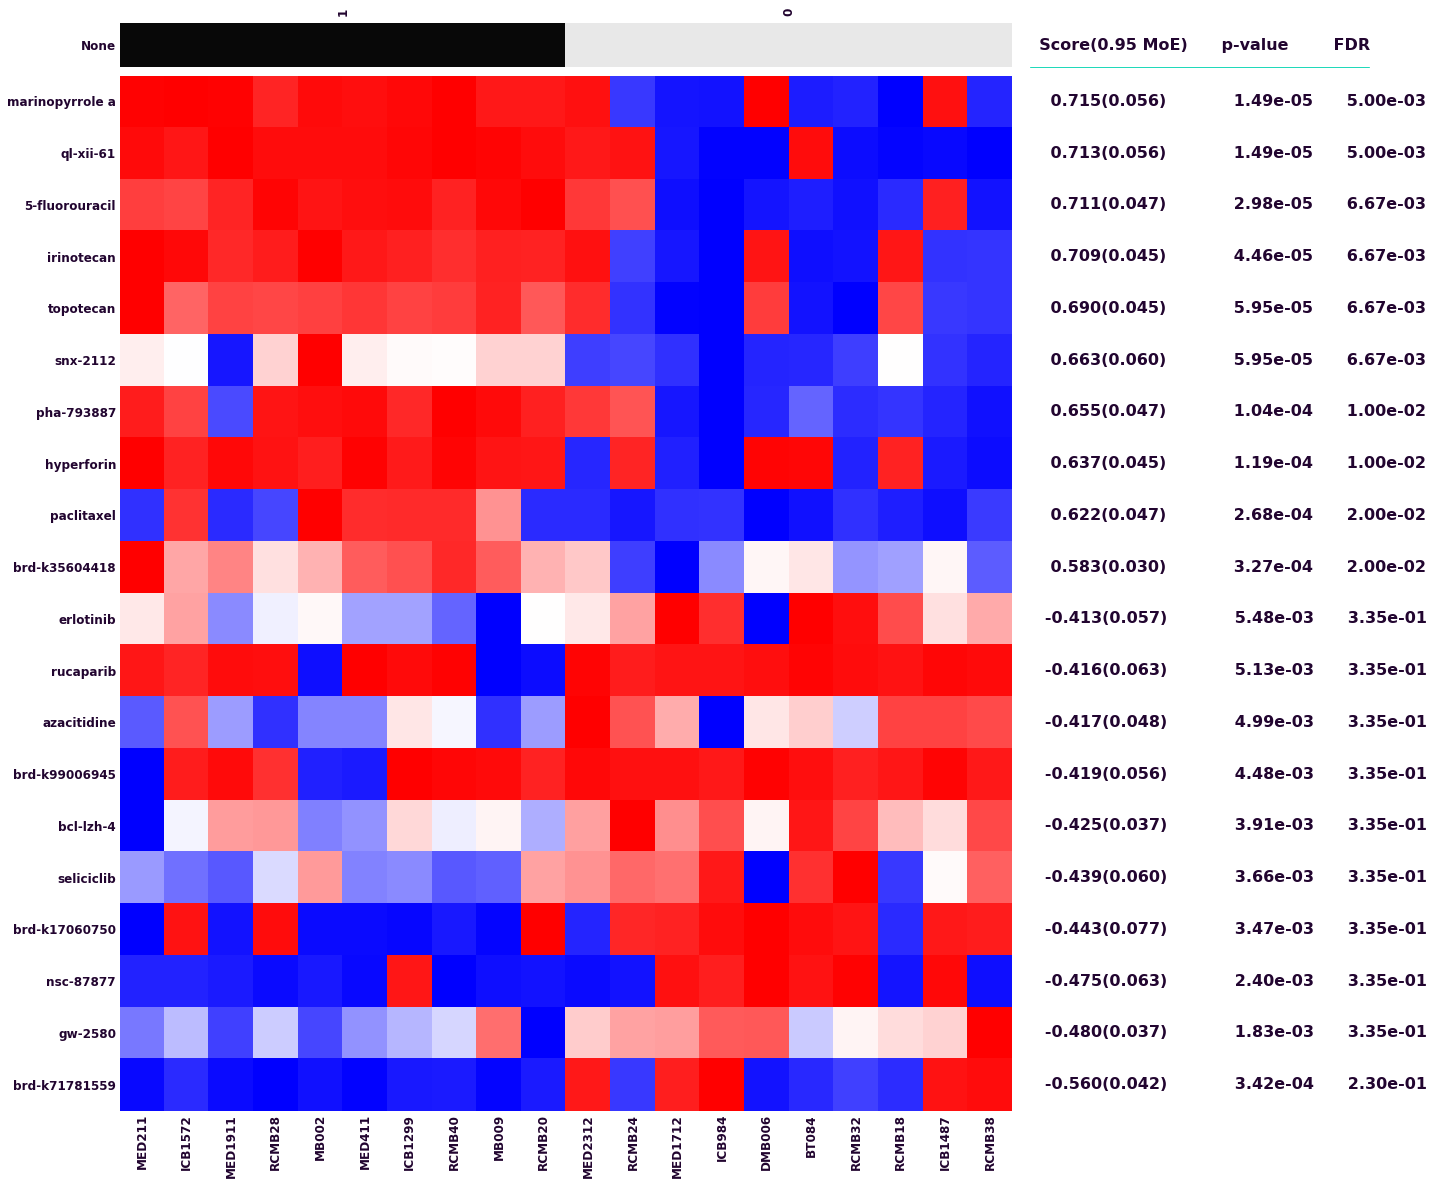

-----
0-->other
1-->G3
-----
File named "results/G3/G3_effective_drugs_from_expression.xlsx" saved successfully!
-----
Effective drugs (i.e., drugs with Score>0)


,MoA,0.95 MoE,p-value,FDR,Score
Name,,,,,
marinopyrrole a,Not Clinically Relevant,0.055646,0.000015,0.005000,0.714686
ql-xii-61,Not Clinically Relevant,0.056195,0.000015,0.005000,0.713319
5-fluorouracil,antimetabolite,0.047322,0.000030,0.006667,0.710768
irinotecan,"aka CPT-11, inhibitor of Topo I",0.045173,0.000045,0.006667,0.709439
topotecan,Topo I inhibitor,0.044894,0.000060,0.006667,0.689591
snx-2112,Not Clinically Relevant,0.060222,0.000060,0.006667,0.663137
pha-793887,"CDK inhibitor, esp CDK2, CDK5 and CDK7",0.046606,0.000104,0.010000,0.655463
hyperforin,"Active ingredient in St. John's Wort, blocks r...",0.044912,0.000119,0.010000,0.637081
paclitaxel,disrupts microtubule dynamics,0.047264,0.000268,0.020000,0.622321


In [6]:
create_subgroup_reports(subgroup='G3', pearson=pearson, number_of_permutations=number_of_permutations)

==> Using Information Coefficient as the "Score"
Dropping 0 axis-1 slices ...
Computing match score with <function information_coefficient at 0x7f6bcc57d9d8> (1 process) ...
Computing MoEs with 30 samplings ...
Computing p-values and FDRs with 100 permutations ...
	1/100 ...
	11/100 ...
	21/100 ...
	31/100 ...
	41/100 ...
	51/100 ...
	61/100 ...
	71/100 ...
	81/100 ...
	91/100 ...
	100/100 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


-----------------------------------------------
The PDF of this heatmap can be downloaded here:



-----------------------------------------------
The TXT with the data displayed on the heatmap can be downloaded here:



-----------------------------------------------
done!


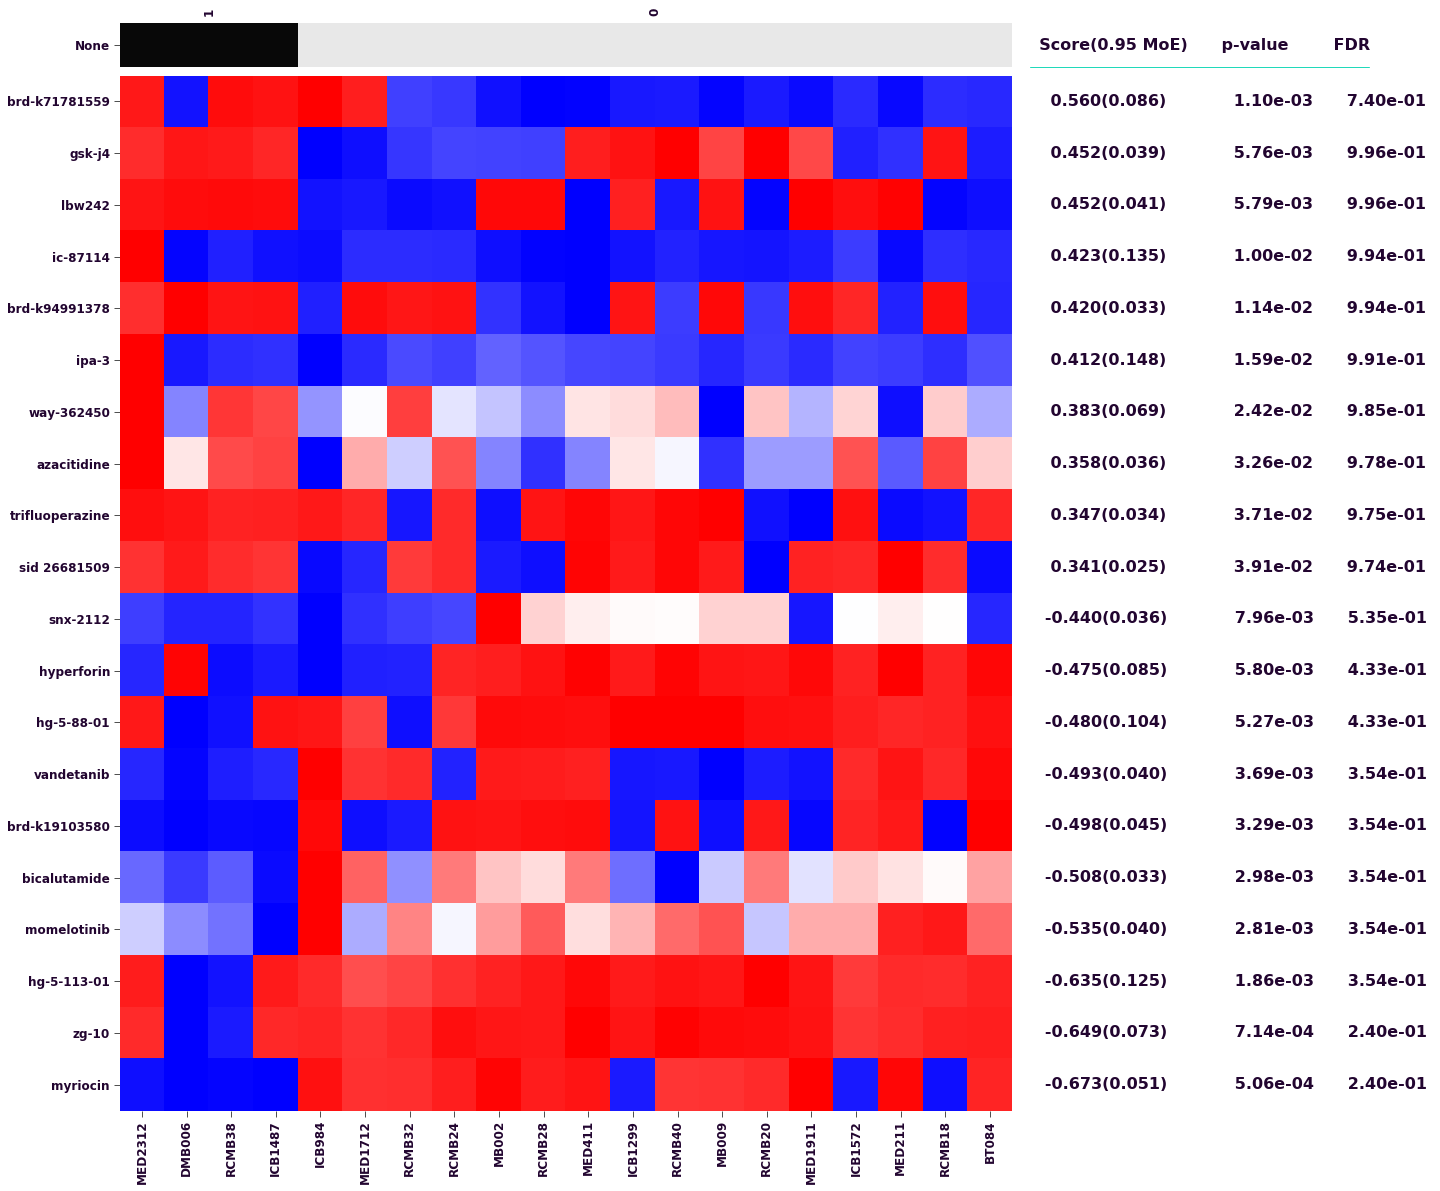

-----
0-->other
1-->G4
-----
File named "results/G4/G4_effective_drugs_from_expression.xlsx" saved successfully!
-----
Effective drugs (i.e., drugs with Score>0)


,MoA,0.95 MoE,p-value,FDR,Score
Name,,,,,
brd-k71781559,Not Clinically Relevant,0.085633,0.001101,0.740000,0.560232
gsk-j4,Not Clinically Relevant,0.038634,0.005759,0.995723,0.452347
lbw242,Not Clinically Relevant,0.040545,0.005789,0.995723,0.452274
ic-87114,Not Clinically Relevant,0.134522,0.010000,0.994439,0.422735
brd-k94991378,Not Clinically Relevant,0.033106,0.011399,0.994439,0.419780
ipa-3,Not Clinically Relevant,0.148067,0.015923,0.991454,0.412455
way-362450,Not Clinically Relevant,0.068656,0.024226,0.984565,0.382631
azacitidine,"Nucleoside analog, inhibitor of DNA methylatio...",0.036128,0.032634,0.977549,0.357663
trifluoperazine,"antipsychotic, antiadrenergic and antidopamine...",0.033523,0.037054,0.974548,0.347404


In [7]:
create_subgroup_reports(subgroup='G4', pearson=pearson, number_of_permutations=number_of_permutations)

==> Using Information Coefficient as the "Score"
Dropping 0 axis-1 slices ...
Computing match score with <function information_coefficient at 0x7f6bcc57d9d8> (1 process) ...
Computing MoEs with 30 samplings ...
Computing p-values and FDRs with 100 permutations ...
	1/100 ...
	11/100 ...
	21/100 ...
	31/100 ...
	41/100 ...
	51/100 ...
	61/100 ...
	71/100 ...
	81/100 ...
	91/100 ...
	100/100 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


-----------------------------------------------
The PDF of this heatmap can be downloaded here:



-----------------------------------------------
The TXT with the data displayed on the heatmap can be downloaded here:



-----------------------------------------------
done!


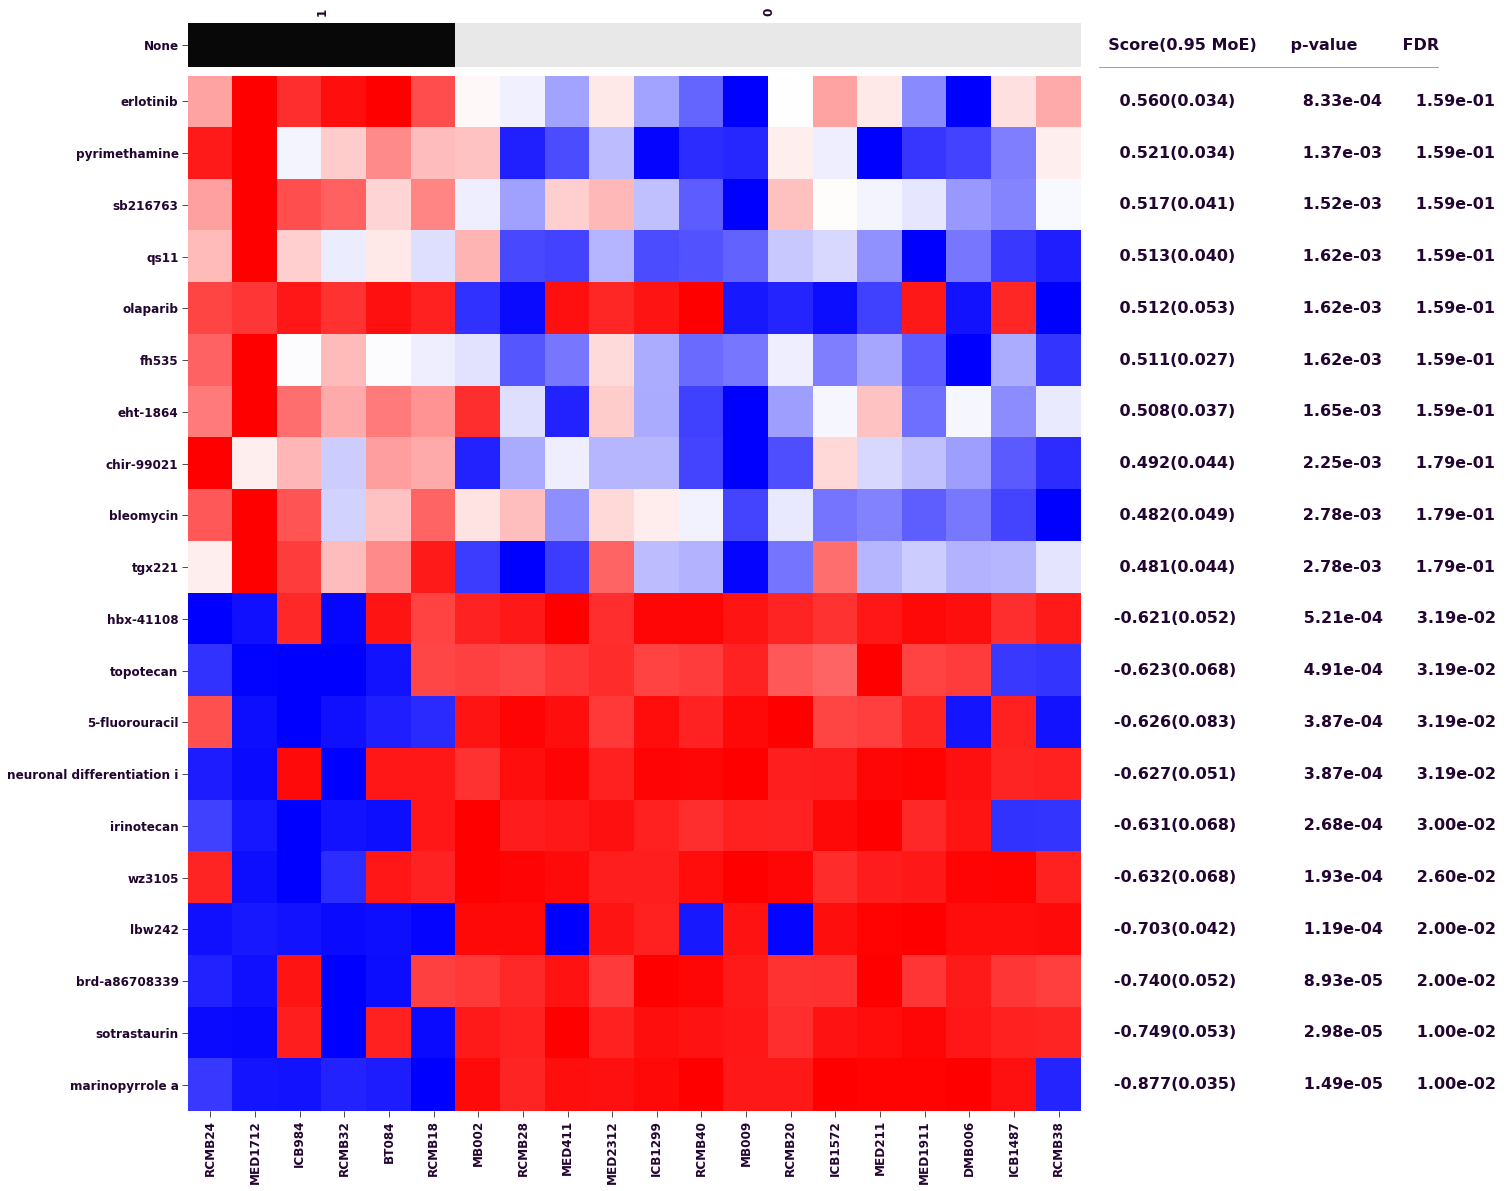

-----
0-->other
1-->SHH
-----
File named "results/SHH/SHH_effective_drugs_from_expression.xlsx" saved successfully!
-----
Effective drugs (i.e., drugs with Score>0)


,MoA,0.95 MoE,p-value,FDR,Score
Name,,,,,
erlotinib,EGFR inhibitor (Tarceva),0.034370,0.000833,0.158571,0.560091
pyrimethamine,Not Clinically Relevant,0.034287,0.001369,0.158571,0.520976
sb216763,Not Clinically Relevant,0.041464,0.001518,0.158571,0.517092
qs11,Not Clinically Relevant,0.039887,0.001622,0.158571,0.512877
olaparib,PARP Inhibitor,0.052987,0.001622,0.158571,0.512432
fh535,Not Clinically Relevant,0.026926,0.001622,0.158571,0.510967
eht-1864,Not Clinically Relevant,0.037444,0.001652,0.158571,0.508470
chir-99021,Not Clinically Relevant,0.043633,0.002247,0.179333,0.491974
bleomycin,"Induces DNA strand breaks, inhibits incorporat...",0.049357,0.002783,0.179333,0.482027


In [8]:
create_subgroup_reports(subgroup='SHH', pearson=pearson, number_of_permutations=number_of_permutations)

==> Using Information Coefficient as the "Score"
Dropping 0 axis-1 slices ...
Computing match score with <function information_coefficient at 0x7f6bcc57d9d8> (1 process) ...
Computing MoEs with 30 samplings ...
Computing p-values and FDRs with 100 permutations ...
	1/100 ...
	11/100 ...
	21/100 ...
	31/100 ...
	41/100 ...
	51/100 ...
	61/100 ...
	71/100 ...
	81/100 ...
	91/100 ...
	100/100 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


-----------------------------------------------
The PDF of this heatmap can be downloaded here:



-----------------------------------------------
The TXT with the data displayed on the heatmap can be downloaded here:



-----------------------------------------------
done!


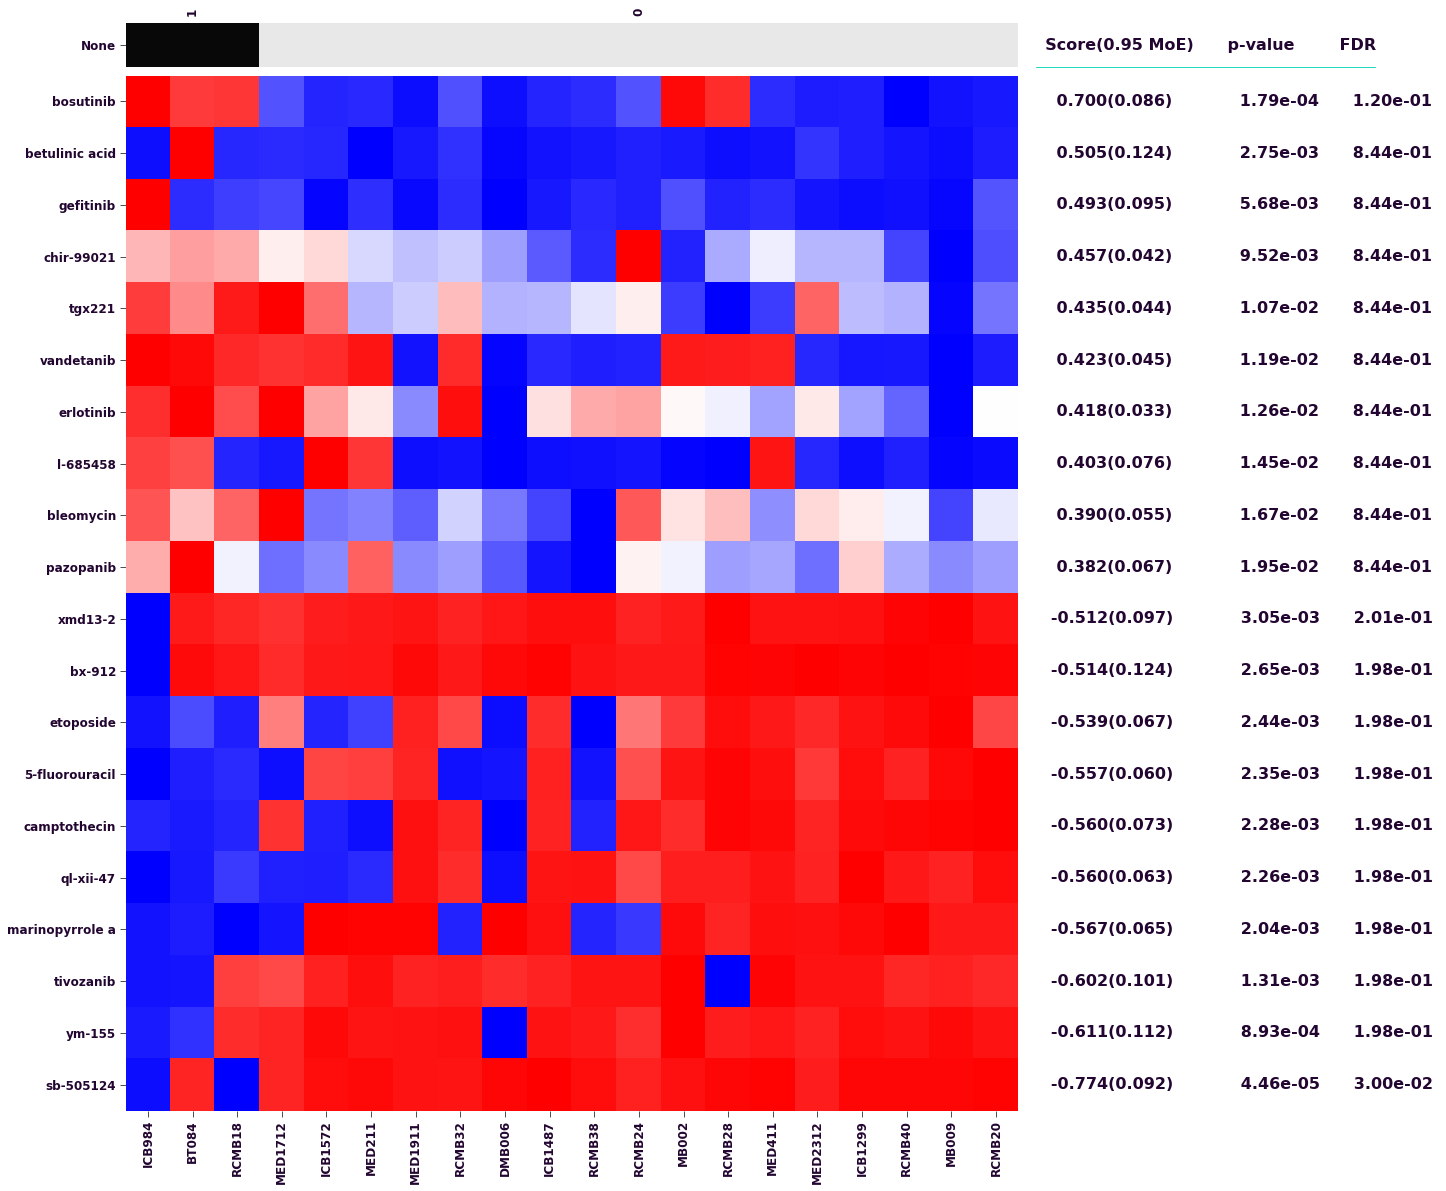

-----
0-->other
1-->SHH+p53
-----
File named "results/SHH+p53/SHH+p53_effective_drugs_from_expression.xlsx" saved successfully!
-----
Effective drugs (i.e., drugs with Score>0)


,MoA,0.95 MoE,p-value,FDR,Score
Name,,,,,
bosutinib,"BCR-Abl, Src, Lyn and Hck inhibitor",0.086056,0.000179,0.120000,0.700202
betulinic acid,Not Clinically Relevant,0.124023,0.002753,0.843625,0.505093
gefitinib,EGFR inhibitor (Iressa),0.095144,0.005685,0.843625,0.492702
chir-99021,Not Clinically Relevant,0.041896,0.009524,0.843625,0.456730
tgx221,Not Clinically Relevant,0.043638,0.010655,0.843625,0.434567
vandetanib,"VEGFR, EGFR and RET inhibitor",0.045396,0.011860,0.843625,0.423195
erlotinib,EGFR inhibitor (Tarceva),0.032735,0.012619,0.843625,0.418359
l-685458,Not Clinically Relevant,0.075914,0.014524,0.843625,0.402678
bleomycin,"Induces DNA strand breaks, inhibits incorporat...",0.054951,0.016741,0.843625,0.390461


In [9]:
create_subgroup_reports(subgroup='SHH+p53', pearson=pearson, number_of_permutations=number_of_permutations)

In [10]:
concatenate_subgroup_reports()

Sheet named "G3" added successfully to file named "results/effective_drugs_from_expression.xlsx"!
Sheet named "G4" added successfully to file named "results/effective_drugs_from_expression.xlsx"!
Sheet named "SHH" added successfully to file named "results/effective_drugs_from_expression.xlsx"!
Sheet named "SHH+p53" added successfully to file named "results/effective_drugs_from_expression.xlsx"!
All done!
